In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [36]:
regions = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']
fire_regions = ['Estimated_fire_area_{}'.format(i) for i in regions]

In [61]:
regions

['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']

In [728]:
merge_df = pd.DataFrame()
for i,x in zip(regions, fire_regions):
    df = pd.read_csv('{}_iso.csv'.format(i))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[['Date', x]]
    df = pd.melt(df, id_vars = 'Date', value_vars = x)
    df['variable'] = df['variable'].replace(to_replace = x, value = i)
    merge_df = pd.concat([merge_df, df])
    merge_df.reset_index(drop=True, inplace=True)
    
merge_df.rename(columns = {'value':'Estimated_fire_area'}, inplace=True)

In [730]:
_midmonth_of_year = [
  15.5,   # the middle of January is betwen Day 15-16
  45,     # February
  75,     # March
  106,    # April
  136.5,
  167,
  197.5,
  228.5,
  259,
  289.5,
  320,
  350.5   # December
]
# total number of years in dataframe
_len = len(merge_df) - 1
_total_years = merge_df.loc[_len, 'Date'].year - merge_df.loc[0, 'Date'].year +1 
_cumulative = []
# creating a list of cumulative middays of the year
# For exmaple _cumulative[0] would be the cumulative middays of the first year
# and _cumulative[1] would be the cumulative middays of second year
for i in range(_total_years):
    _cumulative.append(np.array(_midmonth_of_year) + (i * 365.2425)) # total number of days
    
    
# I will need to transpose this list to get cumulative middays for January and February
_array = np.array(_cumulative)

_start_day = merge_df.loc[0, 'Date'].dayofyear
_day_range = np.array(range(_start_day, len(merge_df) + 1))

alpha = 310 # change alpha to make bumps thinner or thicker
for i, month in zip(_array.T, range(1,13)):
    _list = []
    for each in i:
        _list.append(np.exp(-1/(alpha) * (_day_range - each)**2))

    _list = np.array(_list)
    _max = _list.max(axis = 0)

    merge_df['month_{}'.format(month)] = _max

In [731]:
import datetime
date_time = pd.to_datetime(merge_df['Date'], format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day
merge_df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
merge_df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
# merge_df['month'] = merge_df['Date'].dt.month
# merge_df['dayofweek'] = merge_df['Date'].dt.dayofweek

In [732]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
merge_df['variable'] = le.fit_transform(merge_df['variable'])
merge_df

,Date,variable,Estimated_fire_area,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_sin,year_cos
0,2005-01-01,0,0.000000,0.507517,0.001940,2.130091e-08,3.585311e-16,1.897618e-26,2.485555e-39,8.056949e-55,3.105164e-73,5.586864e-94,2.487621e-117,2.741151e-143,7.475055e-172,0.012400,0.999923
1,2005-01-02,0,0.000000,0.555491,0.002568,3.422455e-08,7.035994e-16,4.533831e-26,7.229992e-39,2.853271e-54,1.343123e-72,2.942099e-93,1.594892e-116,2.139627e-142,7.103583e-171,0.029599,0.999562
2,2005-01-03,0,0.000000,0.604090,0.003379,5.463557e-08,1.371899e-15,1.076267e-25,2.089538e-38,1.003953e-53,5.772251e-72,1.539376e-92,1.015960e-115,1.659363e-141,6.707159e-170,0.046789,0.998905
3,2005-01-04,0,8.680000,0.652716,0.004416,8.665854e-08,2.657766e-15,2.538473e-25,6.000135e-38,3.509797e-53,2.464749e-71,8.002580e-92,6.430134e-115,1.278623e-140,6.292133e-169,0.063965,0.997952
4,2005-01-05,0,16.611250,0.700721,0.005734,1.365668e-07,5.115754e-15,5.948718e-25,1.711866e-37,1.219126e-52,1.045679e-70,4.133458e-91,4.043538e-114,9.789084e-140,5.864827e-168,0.081122,0.996704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40476,2020-10-27,6,32.970000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.900812,0.434210
40477,2020-10-28,6,20.840625,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.893209,0.449641
40478,2020-10-29,6,136.083077,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.885342,0.464940
40479,2020-10-30,6,42.397895,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.877214,0.480100


In [733]:
# merge_df['Estimated_fire_area'] = np.sqrt(merge_df['Estimated_fire_area'])

In [734]:
# Creating 3 sliced dataframes
train_set = merge_df.loc[merge_df['Date'] <= '2019-10-31'].copy(deep=True)
test_set = merge_df.loc[(merge_df['Date'] > '2019-10-31') & (merge_df['Date'] <= '2020-02-28')].copy(deep=True)
pred_set = merge_df.loc[(merge_df['Date'] > '2019-10-31') & (merge_df['Date'] <= '2020-02-28')].copy(deep=True)
pred_set['Estimated_fire_area'] = np.nan
print(pred_set.shape)
pred_set.tail()

(840, 17)


,Date,variable,Estimated_fire_area,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_sin,year_cos
40230,2020-02-24,6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.801849,0.597526
40231,2020-02-25,6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.812009,0.583645
40232,2020-02-26,6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.821929,0.569590
40233,2020-02-27,6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.831605,0.555367
40234,2020-02-28,6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.841036,0.540980


In [735]:
test_set['variable'] = le.inverse_transform(test_set['variable'])

In [736]:
def date_lags(_df):
    """
    creates lag 7 and lag 28 features from values.
    creates ma7_lag7, ma7_lag28, ma28_lag7, ma28_lag28.
    
    """
    
    _df['lag_1'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(1)
    _df['lag_2'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(2)
    _df['lag_3'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(3)
    _df['lag_4'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(4)
    _df['lag_5'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(5)
    _df['lag_6'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(6)
    _df['lag_7'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(7)
    _df['lag_28'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(28)

    _df['mean_lag7_roll7'] = _df[['variable', 'Estimated_fire_area', 'lag_7']].groupby('variable')['lag_7'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag7_roll28'] = _df[['variable', 'Estimated_fire_area', 'lag_7']].groupby('variable')['lag_7'].apply(lambda x: x.rolling(28).mean())
#     _df['mean_lag28_roll7'] = _df[['variable', 'Estimated_fire_area', 'lag_28']].groupby('variable')['lag_28'].apply(lambda x: x.rolling(7).mean())
#     _df['mean_lag28_roll28'] = _df[['variable', 'Estimated_fire_area', 'lag_28']].groupby('variable')['lag_28'].apply(lambda x: x.rolling(28).mean())
    
    return _df

In [737]:
train_set = date_lags(train_set)

In [746]:
categorical_features = ['variable']
useless_cols = ['Date', 'Estimated_fire_area']
train_cols = [x for x in train_set.columns if x not in useless_cols]
_X = train_set[train_cols]
_y = train_set['Estimated_fire_area']

In [747]:

X_valid = train_set.loc[train_set['Date'] >= '2018-11-01'][train_cols]
y_valid = train_set.loc[train_set['Date'] >= '2018-11-01']['Estimated_fire_area']
X_train = train_set.loc[train_set['Date'] < '2018-11-01'][train_cols]
y_train = train_set.loc[train_set['Date'] < '2018-11-01']['Estimated_fire_area']

In [748]:
import lightgbm as lgb

In [749]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)
y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=categorical_features, free_raw_data=False)

In [750]:
import optuna

In [751]:
def objective(trial):
    params = {
        'objective': trial.suggest_categorical('objective', ['poisson', 'tweedie']),
        'boosting': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 18, 64),
        'num_leaves': trial.suggest_int('num_leaves', 54, 124),
        'metric' :'mape',

        'learning_rate' : 0.05,


        'bagging_fraction' : trial.suggest_loguniform('bag_frac', 0.5, 0.9),
        'feature_fraction': trial.suggest_loguniform('feat_frac', 0.5, 0.9),
        'lambda_l1' : trial.suggest_loguniform('l1', 0.1, 0.9),
        'lambda_l2' : trial.suggest_loguniform('l2', 0.1, 0.9),

        'verbosity': 1}


    m_lgb = lgb.train(params, train_data,num_boost_round=25000, valid_sets = y_valid_data, verbose_eval=1000, early_stopping_rounds=500)
    
    train_roll = train_set.copy(deep=True)
    try:
        for i in tqdm(range(1,500)):
            _to_pred = pred_set.loc[pred_set['Date'] == (datetime.datetime(2019, 10, 31) + datetime.timedelta(days= i))].copy()
            _first_concat = pd.concat([train_roll, _to_pred])
            _first_concat.reset_index(inplace=True, drop=True)
            _first_concat = date_lags(_first_concat)
            _to_pred = _first_concat.loc[_first_concat['Date'] == (datetime.datetime(2019, 10, 31) + datetime.timedelta(days= i))].copy()
            _to_pred_feats = _to_pred[train_cols]
            first_pred = m_lgb.predict(_to_pred_feats)
            _to_pred['Estimated_fire_area'] = first_pred
            train_roll = pd.concat([train_roll, _to_pred])
    except:
        print('end of loop')
    
    
    _pred_set = train_roll.loc[(train_roll['Date'] >= '2019-11-01') & (train_roll['Date'] <= '2020-02-28')].copy(deep=True)
    _pred_set['variable'] = le.inverse_transform(_pred_set['variable'])
    _pred_pivot = pd.pivot(_pred_set[['Date', 'variable', 'Estimated_fire_area']], index = 'Date', columns = 'variable')
    
#     test_set['variable'] = le.inverse_transform(test_set['variable'])
    _test_pivot = pd.pivot(test_set[['Date', 'variable', 'Estimated_fire_area']], index = 'Date', columns = 'variable')
    _lgbm_rmse = mean_squared_error(_test_pivot.values.flatten(), _pred_pivot.values.flatten())
    
    return _lgbm_rmse

In [755]:
# study = optuna.create_study()
# study.optimize(objective, n_trials=100)

In [753]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 55,
    'num_leaves': 63,
    'metric' :'mape',
    'learning_rate' : 0.05,

    'bagging_fraction' : 0.8586230379455113,
    'feature_fraction': 0.5075743082081623,
    'lambda_l1' : 0.2720377201421843,
    'lambda_l2' : 0.3814253476194106,
    'verbosity': 1

}

In [674]:
# {'objective': 'poisson', 'max_depth': 55, 'num_leaves': 63, 'bag_frac': 0.8586230379455113, 'feat_frac': 0.5075743082081623, 'l1': 0.2720377201421843, 'l2': 0.3814253476194106}

In [754]:
m_lgb = lgb.train(params, train_data,num_boost_round=50000, valid_sets = y_valid_data, verbose_eval=500, early_stopping_rounds=500)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's mape: 2.36869
[1000]	valid_0's mape: 2.26928
[1500]	valid_0's mape: 2.15915
[2000]	valid_0's mape: 2.07949
[2500]	valid_0's mape: 2.00105
[3000]	valid_0's mape: 1.94601
[3500]	valid_0's mape: 1.88145
[4000]	valid_0's mape: 1.82312
[4500]	valid_0's mape: 1.78372
[5000]	valid_0's mape: 1.74439
[5500]	valid_0's mape: 1.70972
[6000]	valid_0's mape: 1.67803
[6500]	valid_0's mape: 1.65238
[7000]	valid_0's mape: 1.63026
[7500]	valid_0's mape: 1.60933
[8000]	valid_0's mape: 1.58984
[8500]	valid_0's mape: 1.56794
[9000]	valid_0's mape: 1.53957
[9500]	valid_0's mape: 1.5182
[10000]	valid_0's mape: 1.50011
[10500]	valid_0's mape: 1.48048
[11000]	valid_0's mape: 1.46732
[11500]	valid_0's mape: 1.45387
[12000]	valid_0's mape: 1.44023
[12500]	valid_0's mape: 1.43077
[13000]	valid_0's mape: 1.42016
[13500]	valid_0's mape: 1.40878
[14000]	valid_0's mape: 1.39671
[14500]	valid_0's mape: 1.38773
[15000]	valid_0's mape: 1.37857

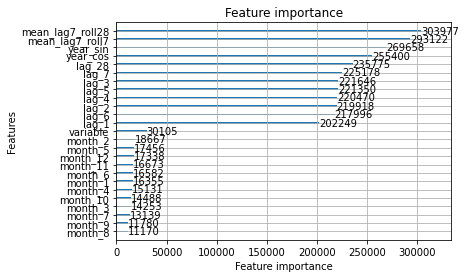

In [756]:
lgb.plot_importance(m_lgb)

In [757]:
from tqdm import tqdm

In [758]:
train_roll = train_set.copy(deep=True)
try:
    for i in tqdm(range(1,500)):
        _to_pred = pred_set.loc[pred_set['Date'] == (datetime.datetime(2019, 10, 31) + datetime.timedelta(days= i))].copy()
        _first_concat = pd.concat([train_roll, _to_pred])
        _first_concat.reset_index(inplace=True, drop=True)
        _first_concat = date_lags(_first_concat)
        _to_pred = _first_concat.loc[_first_concat['Date'] == (datetime.datetime(2019, 10, 31) + datetime.timedelta(days= i))].copy()
        _to_pred_feats = _to_pred[train_cols]
        first_pred = m_lgb.predict(_to_pred_feats)
        _to_pred['Estimated_fire_area'] = first_pred
        train_roll = pd.concat([train_roll, _to_pred])
except:
    print('end of loop')

 24%|██▍       | 120/499 [00:16<00:52,  7.23it/s]


end of loop


In [759]:
train_roll

,Date,variable,Estimated_fire_area,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28
0,2005-01-01,0,0.000000,0.507517,0.001940,2.130091e-08,3.585311e-16,1.897618e-26,2.485555e-39,8.056949e-55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-02,0,0.000000,0.555491,0.002568,3.422455e-08,7.035994e-16,4.533831e-26,7.229992e-39,2.853271e-54,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-03,0,0.000000,0.604090,0.003379,5.463557e-08,1.371899e-15,1.076267e-25,2.089538e-38,1.003953e-53,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-01-04,0,8.680000,0.652716,0.004416,8.665854e-08,2.657766e-15,2.538473e-25,6.000135e-38,3.509797e-53,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-01-05,0,16.611250,0.700721,0.005734,1.365668e-07,5.115754e-15,5.948718e-25,1.711866e-37,1.219126e-52,...,8.680000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38754,2020-02-28,2,33.284424,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,29.883725,35.198156,35.651841,40.295711,29.916242,29.491484,28.687527,43.302142,22.853054,27.455103
38755,2020-02-28,3,2.492094,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.311870,2.234702,1.331134,0.471159,0.368879,0.514529,0.503022,0.953032,0.468218,0.600786
38756,2020-02-28,4,0.654254,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.580889,0.520889,0.133166,0.488723,0.547172,0.663084,1.007838,0.238417,2.107693,0.846470
38757,2020-02-28,5,2.143662,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.133912,1.389661,1.500283,1.250847,1.607946,0.384374,0.222663,0.400175,0.333515,0.595783


In [760]:
_pred_set = train_roll.loc[(train_roll['Date'] >= '2019-11-01') & (train_roll['Date'] <= '2020-02-28')]
_pred_set['variable'] = le.inverse_transform(_pred_set['variable'])
_pred_pivot = pd.pivot(_pred_set[['Date', 'variable', 'Estimated_fire_area']], index = 'Date', columns = 'variable')
_pred_set

C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,variable,Estimated_fire_area,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28
37919,2019-11-01,NSW,50.945050,7.564963e-09,2.324906e-16,1.682594e-26,1.254131e-39,2.571271e-40,2.970450e-27,8.492378e-17,...,111.773824,20.214211,123.313373,167.843429,175.634565,397.187261,41.374375,20.708333,131.100527,70.235469
37920,2019-11-01,NT,62.734098,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,30.140000,131.171667,85.603235,18.578571,22.420000,101.147042,125.942169,402.668624,703.829040,469.715529
37921,2019-11-01,QL,33.537133,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,25.846154,0.000000,11.215556,87.723636,50.888889,31.020000,31.609091,157.797391,127.893016,170.490849
37922,2019-11-01,SA,38.977763,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,96.043200,66.883902,69.400278,143.403061,70.229744,59.528182,154.612500,378.278599,54.710357,52.593429
37923,2019-11-01,TA,1.613073,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,25.066667,1.000000,20.520000,1.210000,0.000000,0.000000,0.000000,0.000000,0.992143,0.509107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38754,2020-02-28,QL,33.284424,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,29.883725,35.198156,35.651841,40.295711,29.916242,29.491484,28.687527,43.302142,22.853054,27.455103
38755,2020-02-28,SA,2.492094,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.311870,2.234702,1.331134,0.471159,0.368879,0.514529,0.503022,0.953032,0.468218,0.600786
38756,2020-02-28,TA,0.654254,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.580889,0.520889,0.133166,0.488723,0.547172,0.663084,1.007838,0.238417,2.107693,0.846470
38757,2020-02-28,VI,2.143662,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.133912,1.389661,1.500283,1.250847,1.607946,0.384374,0.222663,0.400175,0.333515,0.595783


In [761]:
_pred_set

,Date,variable,Estimated_fire_area,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28
37919,2019-11-01,NSW,50.945050,7.564963e-09,2.324906e-16,1.682594e-26,1.254131e-39,2.571271e-40,2.970450e-27,8.492378e-17,...,111.773824,20.214211,123.313373,167.843429,175.634565,397.187261,41.374375,20.708333,131.100527,70.235469
37920,2019-11-01,NT,62.734098,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,30.140000,131.171667,85.603235,18.578571,22.420000,101.147042,125.942169,402.668624,703.829040,469.715529
37921,2019-11-01,QL,33.537133,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,25.846154,0.000000,11.215556,87.723636,50.888889,31.020000,31.609091,157.797391,127.893016,170.490849
37922,2019-11-01,SA,38.977763,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,96.043200,66.883902,69.400278,143.403061,70.229744,59.528182,154.612500,378.278599,54.710357,52.593429
37923,2019-11-01,TA,1.613073,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,25.066667,1.000000,20.520000,1.210000,0.000000,0.000000,0.000000,0.000000,0.992143,0.509107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38754,2020-02-28,QL,33.284424,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,29.883725,35.198156,35.651841,40.295711,29.916242,29.491484,28.687527,43.302142,22.853054,27.455103
38755,2020-02-28,SA,2.492094,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.311870,2.234702,1.331134,0.471159,0.368879,0.514529,0.503022,0.953032,0.468218,0.600786
38756,2020-02-28,TA,0.654254,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.580889,0.520889,0.133166,0.488723,0.547172,0.663084,1.007838,0.238417,2.107693,0.846470
38757,2020-02-28,VI,2.143662,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.133912,1.389661,1.500283,1.250847,1.607946,0.384374,0.222663,0.400175,0.333515,0.595783


In [762]:
# test_set['variable'] = le.inverse_transform(test_set['variable'])

In [763]:
_test_pivot = pd.pivot(test_set[['Date', 'variable', 'Estimated_fire_area']], index = 'Date', columns = 'variable')

In [764]:
from sklearn.metrics import mean_squared_error

In [765]:
mean_squared_error(_test_pivot.values.flatten(), _pred_pivot.values.flatten())

271554.49225809023

In [766]:
_test_pivot

Estimated_fire_area                                              \
variable                   NSW          NT         QL         SA   TA   VI   
Date                                                                         
2019-11-01          126.333187   68.370714  24.507143   0.000000  0.0  0.0   
2019-11-02           79.587368  103.395556  40.510833  11.597143  0.0  0.0   
2019-11-03           13.970000   45.084545  43.038667   4.680000  0.0  0.0   
2019-11-04          108.308571   10.412500  46.405882   0.000000  0.0  0.0   
2019-11-05           48.942121   23.124545  62.456333  20.750000  0.0  0.0   
...                        ...         ...        ...        ...  ...  ...   
2020-02-24            0.000000    0.000000   0.000000  15.580000  0.0  0.0   
2020-02-25            0.000000    0.000000   0.000000   0.000000  0.0  0.0   
2020-02-26            0.000000    1.000000   0.000000   0.000000  0.0  0.0   
2020-02-27            7.911429    0.000000   1.430000   0.000000  0.0  0.0   
2020-02-28            5.508000    0.000000   9.293333   0.000000  1.0  3.3   

                        
variable            WA  
Date                    
2019-11-01  127.060357  
2019-11-02  246.085714  
2019-11-03  411.561429  
2019-11-04  857.290658  
2019-11-05  948.480000  
...                ...  
2020-02-24    1.000000  
2020-02-25    2.860000  
2020-02-26    7.200000  
2020-02-27   19.152500  
2020-02-28    0.000000  

[120 rows x 7 columns]

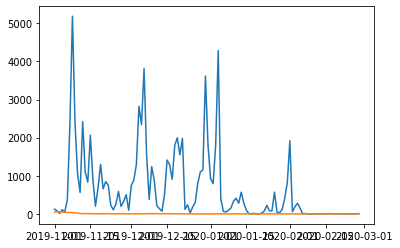

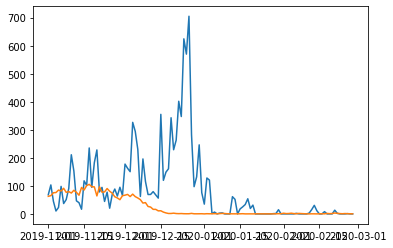

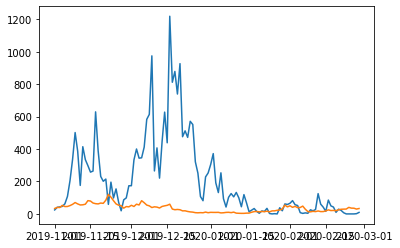

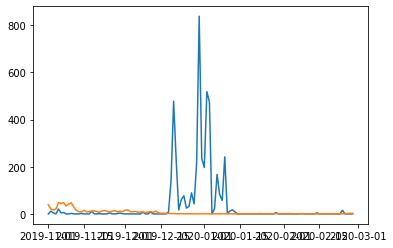

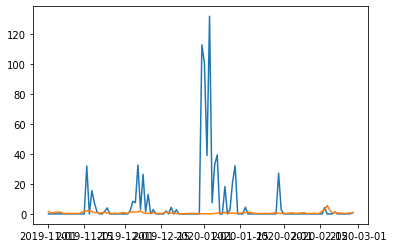

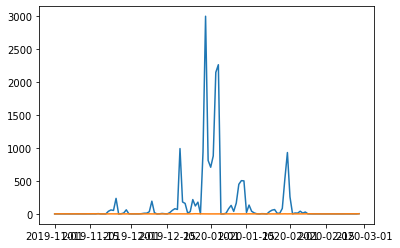

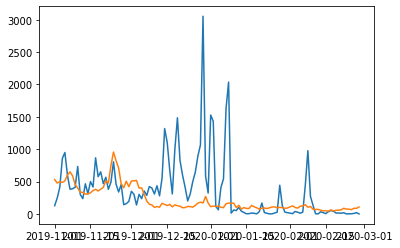

In [767]:
for i,x in zip(_test_pivot.columns, _pred_pivot.columns):
    plt.plot(_test_pivot[i])
    plt.plot(_pred_pivot[i])
    plt.show();

In [585]:
submission = _pred_set[['variable', 'Date', 'Estimated_fire_area']]
submission.rename(columns = {'variable':'Region'}, inplace=True)

,variable,Date,Estimated_fire_area
37919,NSW,2019-11-01,2.620821
37920,NT,2019-11-01,16.225282
37921,QL,2019-11-01,11.336461
37922,SA,2019-11-01,1.521631
37923,TA,2019-11-01,0.056835
...,...,...,...
38754,QL,2020-02-28,4.356298
38755,SA,2020-02-28,0.627244
38756,TA,2020-02-28,0.876984
38757,VI,2020-02-28,1.991241


In [586]:

submission

C:\Users\albert\Anaconda3\lib\site-packages\pandas\core\frame.py:4446: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Region,Date,Estimated_fire_area
37919,NSW,2019-11-01,2.620821
37920,NT,2019-11-01,16.225282
37921,QL,2019-11-01,11.336461
37922,SA,2019-11-01,1.521631
37923,TA,2019-11-01,0.056835
...,...,...,...
38754,QL,2020-02-28,4.356298
38755,SA,2020-02-28,0.627244
38756,TA,2020-02-28,0.876984
38757,VI,2020-02-28,1.991241


In [588]:
regions

['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']

In [589]:
submission_df = pd.DataFrame()
for i in regions:
    submission_df = pd.concat([submission_df, submission.loc[submission['Region'].eq(i)]])

In [591]:
submission_df.reset_index(drop=True, inplace=True)
# submisison_df

NameError: name 'submisison_df' is not defined

In [597]:
submission_df = submission_df.loc[submission_df['Date'].gt('2020-01-31')]

In [601]:
submission_df.to_csv('Phase_1_lgbm.csv', index=False,header=True)

In [600]:
submission_df['Estimated_fire_area'] = np.power(submission_df['Estimated_fire_area'], 2)

C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [578]:
_pred_pivot

Estimated_fire_area                                            \
variable                   NSW         NT         QL        SA        TA   
Date                                                                       
2019-11-01            2.620821  16.225282  11.336461  1.521631  0.056835   
2019-11-02            8.608570  11.680335  10.671182  1.712693  0.051927   
2019-11-03            8.264677   9.888339   9.048408  1.522540  0.044817   
2019-11-04            6.130081   9.096267  10.165486  1.569458  0.131671   
2019-11-05            3.737626  11.788135   6.845761  2.922610  0.341383   
...                        ...        ...        ...       ...       ...   
2020-02-24            1.140117   0.475645   4.436146  0.084776  0.239806   
2020-02-25            0.975501   0.970482   5.441994  0.082467  0.305461   
2020-02-26            1.380833   1.007002   4.236786  0.116785  0.336589   
2020-02-27            0.877717   0.648995   4.819433  0.113833  0.203249   
2020-02-28            2.386488   0.799232   4.356298  0.627244  0.876984   

                                 
variable          VI         WA  
Date                             
2019-11-01  0.974480  16.970946  
2019-11-02  0.772099  17.531670  
2019-11-03  0.173421  20.257015  
2019-11-04  0.292029  14.358958  
2019-11-05  1.256060  17.051505  
...              ...        ...  
2020-02-24  1.412503   7.258274  
2020-02-25  1.952571   6.988487  
2020-02-26  2.148924   6.220350  
2020-02-27  1.455482   6.026007  
2020-02-28  1.991241   5.510946  

[120 rows x 7 columns]

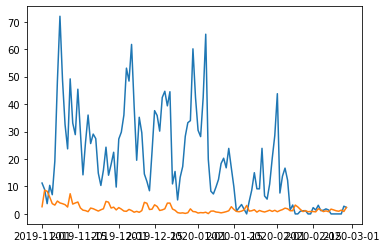

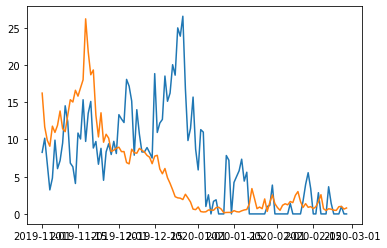

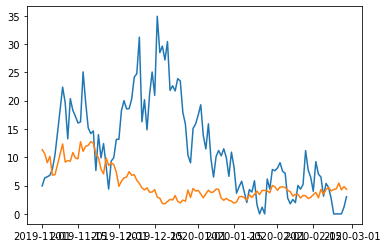

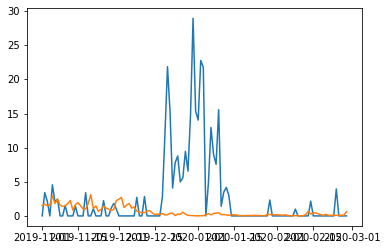

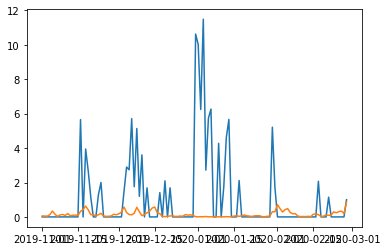

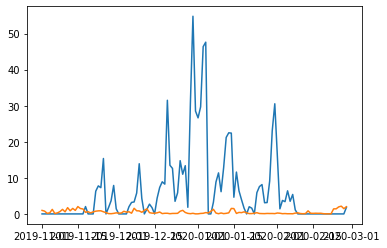

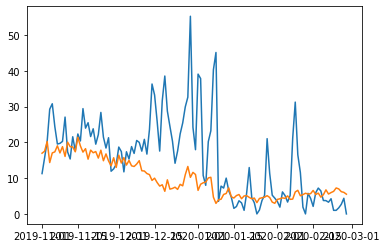

In [582]:
for i,x in zip(_test_pivot.columns, _pred_pivot.columns):
    plt.plot(_test_pivot[i])
    plt.plot(_pred_pivot[i])
    plt.show();

In [ ]:
for i in range(7):
    plt.plot(test_set.loc[test_set['variable'].eq(i)]['Date'], np.power(test_set.loc[test_set['variable'].eq(i)]['Estimated_fire_area'],2), label = 'actual')
    plt.plot(_pred_set.loc[_pred_set['variable'].eq(i)]['Date'], np.power(_pred_set.loc[_pred_set['variable'].eq(i)]['Estimated_fire_area'],2), label = 'pred')
    plt.legend()
    plt.show();

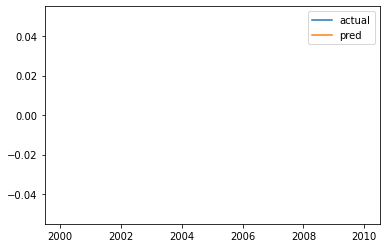

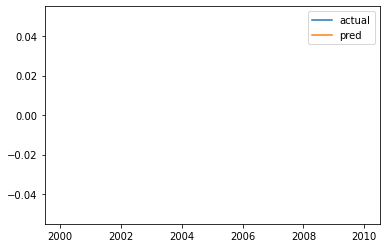

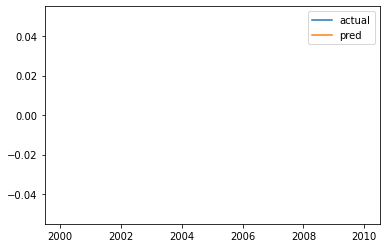

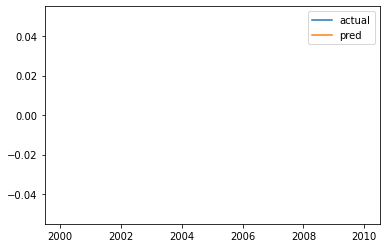

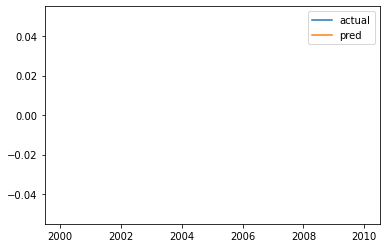

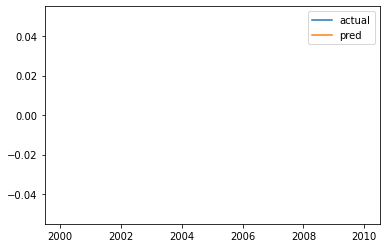

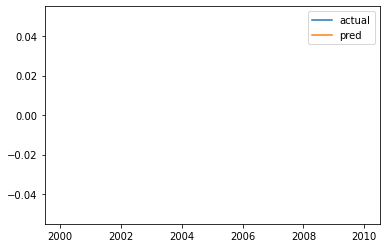

In [577]:
for i in range(7):
    plt.plot(test_set.loc[test_set['variable'].eq(i)]['Date'], np.power(test_set.loc[test_set['variable'].eq(i)]['Estimated_fire_area'],2), label = 'actual')
    plt.plot(_pred_set.loc[_pred_set['variable'].eq(i)]['Date'], np.power(_pred_set.loc[_pred_set['variable'].eq(i)]['Estimated_fire_area'],2), label = 'pred')
    plt.legend()
    plt.show();

In [436]:
pred_set

,Date,variable,Estimated_fire_area,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_sin,year_cos
5417,2019-11-01,0,NaN,0.000009,2.028483e-10,1.047387e-16,7.602784e-25,2.846372e-25,3.573961e-17,1.086421e-10,0.000009,0.015613,0.633610,0.622500,0.014806,-0.866752,0.498739
5418,2019-11-02,0,NaN,0.000012,3.088971e-10,1.798312e-16,1.477689e-24,1.450089e-25,2.057012e-17,7.064300e-11,0.000007,0.012984,0.595269,0.660715,0.017754,-0.858044,0.513575
5419,2019-11-03,0,NaN,0.000017,4.685104e-10,3.075288e-16,2.860594e-24,7.358016e-26,1.179198e-17,4.575125e-11,0.000005,0.010754,0.557016,0.698478,0.021204,-0.849083,0.528259
5420,2019-11-04,0,NaN,0.000023,7.077623e-10,5.238047e-16,5.515594e-24,3.718686e-26,6.732857e-18,2.951206e-11,0.000004,0.008872,0.519140,0.735450,0.025224,-0.839481,0.543389
5421,2019-11-05,0,NaN,0.000030,1.064924e-09,8.886193e-16,1.059232e-23,1.871893e-26,3.828908e-18,1.896090e-11,0.000003,0.007290,0.481908,0.771289,0.029885,-0.830010,0.557749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40230,2020-02-24,6,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.801849,0.597526
40231,2020-02-25,6,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.812009,0.583645
40232,2020-02-26,6,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.821929,0.569590
40233,2020-02-27,6,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.831605,0.555367


In [133]:
merge_df

,Date,variable,Estimated_fire_area,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,month_11,month_12,year_sin,year_cos,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2005-01-01,0,0.000000,0.501905,0.001751,1.594535e-08,2.001347e-16,7.186876e-27,5.788439e-40,1.045650e-55,...,1.261392e-145,1.170210e-174,0.012400,0.999923,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-02,0,0.000000,0.550163,0.002329,2.581962e-08,3.971192e-16,1.741797e-26,1.713475e-39,3.780609e-55,...,1.018321e-144,1.153871e-173,0.029599,0.999562,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-03,0,0.000000,0.599119,0.003078,4.153534e-08,7.828375e-16,4.193794e-26,5.039022e-39,1.357967e-54,...,8.167168e-144,1.130325e-172,0.046789,0.998905,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-01-04,0,8.680000,0.648167,0.004040,6.638008e-08,1.533114e-15,1.003157e-25,1.472200e-38,4.845835e-54,...,6.507446e-143,1.100021e-171,0.063965,0.997952,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-01-05,0,16.611250,0.696648,0.005269,1.053926e-07,2.982837e-15,2.383871e-25,4.273067e-38,1.717910e-53,...,5.151121e-142,1.063534e-170,0.081122,0.996704,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40476,2020-10-27,6,32.970000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-0.900812,0.434210,114.597826,46.482813,88.496038,52.729278,29.793815,39.596133
40477,2020-10-28,6,20.840625,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-0.893209,0.449641,40.913056,23.490909,85.305761,52.008280,24.420945,37.353286
40478,2020-10-29,6,136.083077,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-0.885342,0.464940,7.560000,21.663750,78.400097,51.306565,23.628909,34.122521
40479,2020-10-30,6,42.397895,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-0.877214,0.480100,15.573333,14.338000,75.010574,50.983995,22.162153,30.465220


In [ ]:
# Creating 3 sliced dataframes
train_set = _ffill_lgbm.loc[_ffill_lgbm['datetime'] <= '2020-09-05'].copy(deep=True)
test_set = _ffill_lgbm.loc[(_ffill_lgbm['datetime'] > '2020-09-05') & (_ffill_lgbm['datetime'] <= '2020-10-10')].copy(deep=True)
pred_set = _ffill_lgbm.loc[(_ffill_lgbm['datetime'] > '2020-09-05')].copy(deep=True)
pred_set['value'] = np.nan
pred_set.tail()

In [24]:
_midmonth_of_year = [
  15.5,   # the middle of January is betwen Day 15-16
  45,     # February
  75,     # March
  106,    # April
  136.5,
  167,
  197.5,
  228.5,
  259,
  289.5,
  320,
  350.5   # December
]
# total number of years in dataframe
_total_years = df.index[-1].year - df.index[0].year
_cumulative = []
# creating a list of cumulative middays of the year
# For exmaple _cumulative[0] would be the cumulative middays of the first year
# and _cumulative[1] would be the cumulative middays of second year
for i in range(_total_years):
    _cumulative.append(np.array(_midmonth_of_year) + (i * 365.2425)) # total number of days

In [25]:
# I will need to transpose this list to get cumulative middays for January and February
_array = np.array(_cumulative)

_start_day = df.index[0].dayofyear
_day_range = np.array(range(_start_day, len(df) + 1))

alpha = 305 # change alpha to make bumps thinner or thicker
for i, month in zip(_array.T, range(1,13)):
    _list = []
    for each in i:
        _list.append(np.exp(-1/(alpha) * (_day_range - each)**2))

    _list = np.array(_list)
    _max = _list.max(axis = 0)

    df['month_{}'.format(month)] = _max

C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [26]:
df

,Estimated_fire_area_QL,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Date,,,,,,,,,,,,,
2005-01-01,38.831579,0.501905,0.001751,1.594535e-08,2.001347e-16,7.186876e-27,5.788439e-40,1.045650e-55,2.011084e-74,1.653610e-95,3.049578e-119,1.261392e-145,1.170210e-174
2005-01-02,64.464286,0.550163,0.002329,2.581962e-08,3.971192e-16,1.741797e-26,1.713475e-39,3.780609e-55,8.910216e-74,8.948496e-95,2.015652e-118,1.018321e-144,1.153871e-173
2005-01-03,47.386585,0.599119,0.003078,4.153534e-08,7.828375e-16,4.193794e-26,5.039022e-39,1.357967e-54,3.921917e-73,4.810820e-94,1.323560e-117,8.167168e-144,1.130325e-172
2005-01-04,30.100000,0.648167,0.004040,6.638008e-08,1.533114e-15,1.003157e-25,1.472200e-38,4.845835e-54,1.714987e-72,2.569451e-93,8.634230e-117,6.507446e-143,1.100021e-171
2005-01-05,4.000000,0.696648,0.005269,1.053926e-07,2.982837e-15,2.383871e-25,4.273067e-38,1.717910e-53,7.450326e-72,1.363370e-92,5.595720e-116,5.151121e-142,1.063534e-170
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-27,78.670769,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.731743e-313,8.819279e-273,3.866276e-236,3.801511e-202,8.383459e-171,4.146618e-142
2020-10-28,119.608649,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.504867e-314,5.002732e-274,2.678711e-237,3.216979e-203,8.665111e-172,5.234844e-143
2020-10-29,249.090625,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.071694e-315,2.819250e-275,1.843789e-238,2.704533e-204,8.897688e-173,6.565468e-144


In [20]:
df['t_plus_1'] = df['Estimated_fire_area_QL'].shift(-1)
df.dropna(inplace=True)

In [21]:
mask = np.random.rand(len(df)) < 0.8
df_train = df.loc[df['Date'].lt('2019-10-31')]
df_test = df.loc[df['Date'].gt('2019-10-31')]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=5405
Testing data set length=365


In [14]:
df_test

,Date,Estimated_fire_area_QL,Count_QL,mean_Precipitation_QL,mean_RelativeHumidity_QL,mean_SoilWaterContent_QL,mean_SolarRadiation_QL,mean_Temperature_QL,mean_WindSpeed_QL,Vegetation_index_mean_QL,month,day_of_week,day,t_plus_1
5418,2019-11-02,40.510833,12.0,0.317762,48.273766,0.139153,23.764711,28.039110,4.781493,0.264373,11,5,2,43.038667
5419,2019-11-03,43.038667,30.0,1.090742,56.790338,0.140779,22.333748,26.442924,3.502362,0.264495,11,6,3,46.405882
5420,2019-11-04,46.405882,17.0,0.661526,43.815789,0.138552,24.717484,26.048211,4.035478,0.264617,11,0,4,62.456333
5421,2019-11-05,62.456333,30.0,0.008828,29.448719,0.130091,29.027167,24.288679,4.480378,0.264739,11,1,5,107.863200
5422,2019-11-06,107.863200,50.0,0.005954,30.781749,0.123387,30.065984,24.883937,2.847185,0.264862,11,2,6,205.548444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5778,2020-10-27,78.670769,65.0,1.769690,41.505174,0.172762,25.084729,23.244205,2.858941,0.289288,10,1,27,119.608649
5779,2020-10-28,119.608649,37.0,1.598588,34.364756,0.165709,28.033695,23.345542,3.272644,0.289288,10,2,28,249.090625
5780,2020-10-29,249.090625,192.0,0.076241,30.359122,0.155046,29.804340,24.280550,2.929369,0.289288,10,3,29,282.538983
5781,2020-10-30,282.538983,118.0,0.131547,33.598036,0.146482,29.096387,25.508412,4.199536,0.289288,10,4,30,297.627826


In [22]:
df.columns

Index(['Date', 'Estimated_fire_area_QL', 'Count_QL', 'mean_Precipitation_QL',
       'mean_RelativeHumidity_QL', 'mean_SoilWaterContent_QL',
       'mean_SolarRadiation_QL', 'mean_Temperature_QL', 'mean_WindSpeed_QL',
       'Vegetation_index_mean_QL', 'month', 'day_of_week', 'day', 't_plus_1'],
      dtype='object')

In [27]:
expr = """t_plus_1 ~ Estimated_fire_area_QL  + Count_QL + mean_Precipitation_QL + mean_RelativeHumidity_QL + mean_SoilWaterContent_QL + mean_SolarRadiation_QL + mean_Temperature_QL + mean_WindSpeed_QL + Vegetation_index_mean_QL + month + day_of_week + day + t_plus_1"""


In [28]:
expr

't_plus_1 ~ Estimated_fire_area_QL  + Count_QL + mean_Precipitation_QL + mean_RelativeHumidity_QL + mean_SoilWaterContent_QL + mean_SolarRadiation_QL + mean_Temperature_QL + mean_WindSpeed_QL + Vegetation_index_mean_QL + month + day_of_week + day + t_plus_1'

In [29]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [30]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [32]:
poisson_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               t_plus_1   No. Observations:                 5405
Model:                            GLM   Df Residuals:                     5391
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4575e+05
Date:                Sat, 09 Jan 2021   Deviance:                   2.6185e+05
Time:                        04:50:07   Pearson chi2:                 2.80e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.1479      0.024    133.547      0.000       3.102       3.194
Estimated_fire_area_QL       0.0004   8.02e-06     53.554      0.000       0.000       0.000
Count_QL                    -0.0003   1.47e-05    -20.044      0.000      -0.000      -0.000
mean_Precipitation_QL       -0.0459      0.001    -35.367      0.000      -0.048      -0.043
mean_RelativeHumidity_QL     0.0274      0.000     87.333      0.000       0.027       0.028
mean_SoilWaterContent_QL    -5.1938      0.075    -68.855      0.000      -5.342      -5.046
mean_SolarRadiation_QL       0.1550      0.001    199.317      0.000       0.154       0.157
mean_Temperature_QL         -0.0449      0.001    -87.207      0.000      -0.046      -0.044
mean_WindSpeed_QL           -0.0660      0.002    -29.700      0.000      -0.070      -0.062
Vegetation_index_mean_QL    -5.2599      0.054    -97.449      0.000      -5.366      -5.154
month                        0.0567      0.001    104.877      0.000       0.056       0.058
day_of_week                 -0.0005      0.001     -0.770      0.441      -0.002       0.001
day                          0.0003      0.000      2.407      0.016    5.89e-05       0.001
t_plus_1                     0.0010   2.28e-06    421.805      0.000       0.001       0.001
============================================================================================
"""

In [33]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
 
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

            mean   mean_se  mean_ci_lower  mean_ci_upper
5417  212.678022  1.075139     210.581194     214.795729
5418  168.954707  0.827722     167.340166     170.584826
5419  190.809223  0.904722     189.044215     192.590711
5420  200.868804  0.735656     199.432107     202.315850
5421  313.264898  1.292620     310.741627     315.808659
...          ...       ...            ...            ...
5777  169.264636  0.693318     167.911197     170.628984
5778  171.819291  0.673463     170.504384     173.144338
5779  262.776475  1.087794     260.653063     264.917185
5780  359.276667  1.547227     356.256920     362.322010
5781  335.816720  1.225102     333.424127     338.226481

[365 rows x 4 columns]


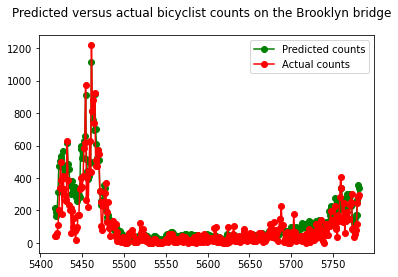

In [36]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['t_plus_1']
 
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
 
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'r', label='Actual counts')
 
plt.legend(handles=[predicted, actual])
 
plt.show()

In [12]:
df_test

,Date,Estimated_fire_area_QL,Count_QL,mean_Precipitation_QL,mean_RelativeHumidity_QL,mean_SoilWaterContent_QL,mean_SolarRadiation_QL,mean_Temperature_QL,mean_WindSpeed_QL,Vegetation_index_mean_QL,month,day_of_week,day,t_plus_1
4,2005-01-05,4.000000,4.0,11.410645,69.268049,0.259284,17.328773,26.426117,3.159938,0.356283,1,2,5,6.050000
5,2005-01-06,6.050000,5.0,12.458772,69.399349,0.297847,18.180887,25.906262,3.414364,0.356083,1,3,6,10.206000
24,2005-01-25,4.306667,3.0,2.717134,64.150893,0.222349,19.143720,26.732306,4.839686,0.352292,1,1,25,0.000000
29,2005-01-30,63.336000,30.0,0.706452,50.736584,0.182364,25.285103,31.623879,2.712835,0.351295,1,6,30,13.780000
30,2005-01-31,13.780000,6.0,1.133515,54.428909,0.180825,25.027935,30.752257,2.617789,0.351095,1,0,31,33.067333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5750,2020-09-29,142.245161,93.0,0.259620,41.856766,0.122774,23.613718,24.345979,4.242764,0.289676,9,1,29,123.744706
5757,2020-10-06,172.383509,114.0,0.598967,49.451108,0.121804,24.332775,24.846377,3.955494,0.289288,10,1,6,136.468958
5760,2020-10-09,407.715642,257.0,0.005139,34.459770,0.117146,27.102414,23.755996,3.927646,0.289288,10,4,9,336.708284
5764,2020-10-13,248.450662,151.0,0.442706,47.358895,0.124066,24.686040,25.240361,4.041879,0.289288,10,1,13,59.546250


In [37]:
import numpy as np
import pyflux as pf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/bankingCrises.csv")
numpy_data = np.sum(data.iloc[:,2:73].values,axis=1)
numpy_data[np.isnan(numpy_data)] = 0
financial_crises = pd.DataFrame(numpy_data)
financial_crises.index = data.year
financial_crises.columns = ["Number of banking crises"]

plt.figure(figsize=(15,5))
plt.plot(financial_crises)
plt.ylabel("Count")
plt.xlabel("Year")
plt.title("Number of banking crises across the world")
plt.show()

ModuleNotFoundError: No module named 'pyflux'

In [ ]:
import sys
!{sys.executable} -m pip install pyflux